In [5]:
import numpy as np
import re, seaborn as sns
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

In [6]:
class calculateFK():

    def __init__(self):
        """
        This is the dimension of the Lynx Robot stated as global variable

        """
        # Lynx Dimensions in mm
        self.L1 = 76.2    # distance between joint 0 and joint 1
        self.L2 = 146.05  # distance between joint 1 and joint 2
        self.L3 = 187.325 # distance between joint 2 and joint 3
        self.L4 = 34      # distance between joint 3 and joint 4
        self.L5 = 34      # distance between joint 4 and center of gripper

        # Joint limits
        self.lowerLim = np.array([-1.4, -1.2, -1.8, -1.9, -2.0, -15]).reshape((1, 6))    # Lower joint limits in radians (grip in mm (negative closes more firmly))
        self.upperLim = np.array([1.4, 1.4, 1.7, 1.7, 1.5, 30]).reshape((1, 6))          # Upper joint limits in radians (grip in mm)

    def forward(self, q):
        """
        INPUT:
        q - 1x6 vector of joint inputs [q0,q1,q2,q3,q4,lg]

        OUTPUTS:
        jointPositions - 6 x 3 matrix, where each row represents one
                  joint along the robot. Each row contains the [x,y,z]
                  coordinates of the respective joint's center (mm). For
                  consistency, the first joint should be located at
                  [0,0,0].
        T0e       - a 4 x 4 homogeneous transformation matrix,
                  representing the end effector frame expressed in the
                  base (0) frame
        """
        # Your code starts from here
        # Frame 1 w.r.t Frame 0
        T1 = np.array([[np.cos(q[0]), -np.sin(q[0])*np.cos(-np.pi/2), np.sin(q[0])*np.sin(-np.pi/2), 0],
                       [np.sin(q[0]), np.cos(q[0])*np.cos(-np.pi/2), -np.cos(q[0])*np.sin(-np.pi/2), 0],
                       [0, np.sin(-np.pi/2), np.cos(-np.pi/2), self.L1],
                       [0, 0, 0, 1]])

        # Frame 2 w.r.t Frame 1
        T2 = np.array([[np.cos(q[1]-(np.pi/2)), -np.sin(q[1]-(np.pi/2)), 0, self.L2*np.cos(q[1]-(np.pi/2))],
                       [np.sin(q[1]-(np.pi/2)), np.cos(q[1]-(np.pi/2)), 0, self.L2*np.sin(q[1]-(np.pi/2))],
                       [0, 0, 1, 0],
                       [0, 0, 0, 1]])

        # Frame 3 w.r.t Frame 2
        T3 = np.array([[np.cos(q[2]+(np.pi/2)), -np.sin(q[2]+(np.pi/2)), 0, self.L3*np.cos(q[2]+(np.pi/2))],
                       [np.sin(q[2]+(np.pi/2)), np.cos(q[2]+(np.pi/2)), 0, self.L3*np.sin(q[2]+(np.pi/2))],
                       [0, 0, 1, 0],
                       [0, 0, 0, 1]])

        # Frame 4 w.r.t Frame 3
        T4 = np.array([[np.cos(q[3]-(np.pi/2)), -np.sin(q[3]-(np.pi/2))*np.cos(-np.pi/2), np.sin(q[3]-(np.pi/2))*np.sin(-np.pi/2), 0],
                       [np.sin(q[3]-(np.pi/2)), np.cos(q[3]-(np.pi/2))*np.cos(-np.pi/2), -np.cos(q[3]-(np.pi/2))*np.sin(-np.pi/2), 0],
                       [0, np.sin(-np.pi/2), np.cos(-np.pi/2), 0],
                       [0, 0, 0, 1]])
        # Frame 5 w.r.t Frame 4
        T5 = np.array([[np.cos(q[4]), -np.sin(q[4]), 0, 0],
                       [np.sin(q[4]), np.cos(q[4]), 0, 0],
                       [0, 0, 1, self.L4 + self.L5],
                       [0, 0, 0, 1]])

        x = np.empty((6, 4)).reshape((6, 4))
        zeroPos = np.array([0, 0, 0, 1]).reshape((1, 4))
        zeroPos_trans = np.transpose(zeroPos)

        # Position of First Joint (Base Revolute)
        x[0, :] = zeroPos

        # Position of Second Joint (Shoulder Revolute)
        x[1, :] = np.transpose(T1.dot(zeroPos_trans))

        # Position of Third Joint (Elbow Revolute)
        x[2, :] = np.transpose((T1.dot(T2)).dot(zeroPos_trans))

        # Position of Fourth Joint (1st Wrist)
        x[3, :] = np.transpose(((T1.dot(T2)).dot(T3)).dot(zeroPos_trans))

        # Position of Fifth Joint (2nd Wrist)
        x[4, :] = np.transpose((((T1.dot(T2)).dot(T3)).dot(T4)).dot(np.array([0, 0, self.L4, 1]).reshape((4, 1))))

        # Position of Gripper (Base of the Gripper)
        x[5, :] = np.transpose(((((T1.dot(T2)).dot(T3)).dot(T4)).dot(T5)).dot(zeroPos_trans))
        # Outputs the 6x3 of the locations of each joint in the Base Frame
        jointPositions = x[0:6,0:3]

        T0e = ((((T1.dot(T2)).dot(T3)).dot(T4)).dot(T5))
        # Your code ends here

        return jointPositions, T0e

In [7]:
def FK_velocity (q, dq, joint):
    """
    :param q: 1 x 6 vector corresponding to the robot's current configuration
    :param dq: 1 x 6 vector corresponding to the robot's current joint velocities
    :param joint: an integer in [0,6] corresponding to which joint you are tracking
    :return:
    v     - The resulting linear velocity in the world frame
    omega - The resulting angular velocity in the world frame
    """
#     d1 = 76.2                      # Distance between joint 0 and joint 1
#     a2 = 146.05                    # Distance between joint 1 and joint 2
#     a3 = 187.325                   # Distance between joint 2 and joint 3
#     d4 = 34                        # Distance between joint 3 and joint 4
#     d5 = 68                        # Distance between joint 3 and joint 5
#     lg = 0                         # Distance between joint 5 and end effector (gripper length)

    v = np.array([0, 0, 0])
    omega = np.array([0, 0, 0])
    
    if(joint == 0 or joint >= 6): return([0.0, 0.0, 0.0], 
                           [0.0, 0.0, 0.0])

#FK_Velocity
    Jac=calcJacobian(q,joint)
#     print(Jac.shape)
    FKvel=np.matmul(Jac,dq[:joint+1]).T
    #print(FKvel)
    v=FKvel[0:3]
    omega=FKvel[3:6]
    return v, omega

In [8]:
def calcJacobian(q, joint):
    
    Jacv=np.zeros((3,6)) #zeroes after col: joint+1
    Jacw=np.zeros((3,6)) #zeroes after col: joint+1
    
    #For loop with the size of 3 x joint
    R=calculateFK()
    
    z=[] # np.array(3,joint)
    z.append(np.array([0,0,1]))
    z.append(np.array([-np.sin(q[0]),np.cos(q[0]),0]))
    z.append(np.array([-np.sin(q[0]),np.cos(q[0]),0]))
    z.append(np.array([-np.sin(q[0]),np.cos(q[0]),0]))
    
    Jp,T0e=R.forward(q)
    z.append([T0e[0,2],T0e[1,2],T0e[2,2]])
    z.append([T0e[0,2],T0e[1,2],T0e[2,2]])
    
    for i in range (1,joint+1):
        Jo=Jp[5]-Jp[i-1]
        Jr=np.cross(z[i-1],Jo)
        Jacv[0,i-1]=Jr[0]
        Jacv[1,i-1]=Jr[1]
        Jacv[2,i-1]=Jr[2]

    z = np.array(z)
    z[joint+1:len(z)] *= 0
    Jacw=np.transpose(np.array(z))
    return (np.append(Jacv, Jacw, axis=0))

In [9]:
#INVERSE KINEMATIC VELOCITY
def IK_velocity (q, v, omega, joint):
    
    Jac=calcJacobian(q,joint)

    vel=np.append(v,omega)
    vind=np.argwhere(np.isnan(vel))

    filteredJac=np.delete(Jac,vind.T,0)
    nv=np.delete(vel,vind.T,0).T

    dq=np.matmul(np.linalg.pinv(filteredJac),nv)
    
    return dq

In [25]:
#CIRCLE TRAJECTORY (INVALID)
# Data for a three-dimensional line
zline = []
xline =[]
yline = []
v=np.array([-10,0,0])
omega=np.array([0]*3)

#for loop through different time steps
q=np.zeros((6))
x = 0.01
R = calculateFK()
jointNum = 5
qdot=IK_velocity (q, v, omega, jointNum)
print(qdot)
for t in range(0,100):
    q=q+qdot
    Jp,_=R.forward(q)
    xline.append(Jp[jointNum][0])
    yline.append(Jp[jointNum][1])
    zline.append(Jp[jointNum][2])

[ 0.00000000e+00 -6.84697022e-02  6.84697022e-02 -3.00129462e-17
 -1.27068978e-17  4.83347171e-18]


In [23]:
#lINE TRAJECTORY (DONT CHANGE)
# Data for a three-dimensional line
zline = []
xline =[]
yline = []
v=np.array([-1,0,0])
omega=np.array([0]*3)

#for loop through different time steps
q=np.zeros((6))
x = 0.01
R = calculateFK()
jointNum = 5
qdot=IK_velocity (q, v, omega, jointNum)
for t in range(0,50):
    q=q+qdot
    qdot=IK_velocity (q, v, omega, jointNum)
    Jp,_=R.forward(q)
    xline.append(Jp[jointNum][0])
    yline.append(Jp[jointNum][1])
    zline.append(Jp[jointNum][2])
    # print(Jp[jointNum])

In [21]:
#PART 3 EVALUATION: CONSTANT DQ TRAJECTORY
# Data for a three-dimensional line
zline = []
xline =[]
yline = []

#for loop through different time steps
q=np.zeros((6))
x = 0.01
dq=np.array([x]*6)
R = calculateFK()
jointNum = 5

for t in range(0,100):
    q=q+dq
    Jp,_=R.forward(q)
    xline.append(Jp[jointNum][0])
    yline.append(Jp[jointNum][1])
    zline.append(Jp[jointNum][2])
    # print(Jp[jointNum])

In [27]:
#CODE TO TEST OUT CIRCLE TRAJECTORY (FINAL ONE DONT CHANGE)
# Data for a three-dimensional line
zline = []
xline =[]
yline = []
v=np.array([np.NaN,10,np.NaN])
omega=np.array([np.NaN,0, np.NaN])

#for loop through different time steps
q=np.zeros((6))
x = 0.01
R = calculateFK()
jointNum = 5
qdot=IK_velocity (q, v, omega, jointNum)
for t in range(0,170):
    qdot=IK_velocity (q, v, omega, jointNum)
    q=q+qdot
    v,omega=FK_velocity (q, qdot,jointNum)
    Jp,_=R.forward(q)
    xline.append(Jp[jointNum][0])
    yline.append(Jp[jointNum][1])
    zline.append(Jp[jointNum][2])
    #print(Jp[jointNum])

In [36]:
#CHECKING FOR SINGULARITIES
# Data for a three-dimensional line
zline = []
xline =[]
yline = []

# v=np.array([0,0,-10])
v=np.array([-10,0,0])

omega=np.array([0]*3)

#for loop through different time steps
q=np.zeros((6))
x = 0.01
R = calculateFK()
jointNum = 5
qdot=IK_velocity (q, v, omega, jointNum)
for t in range(0,100):
    q=q+qdot
    qdot=IK_velocity (q, v, omega, jointNum)
    Jp,_=R.forward(q)
    xline.append(Jp[jointNum][0])
    yline.append(Jp[jointNum][1])
    zline.append(Jp[jointNum][2])
#     print(np.round(q, 2))

Text(0.5, 0, 'Y axis')

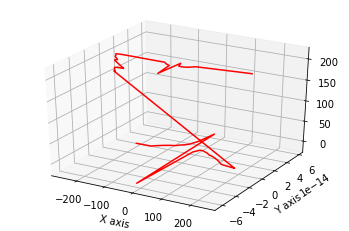

In [32]:
ax = plt.axes(projection='3d')
ax.plot3D(xline, yline, zline, 'red')
plt.xlabel("X axis")
plt.ylabel("Y axis")

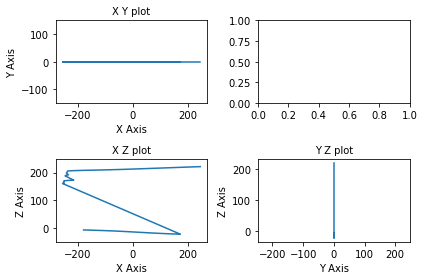

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# Plot circle of radius 3.

fig, axs = plt.subplots(2, 2)

axs[0, 0].plot(xline, yline)
axs[0, 0].set_title('X Y plot', fontsize=10)
axs[0, 0].axis('equal')
axs[0, 0].set_xlabel("X Axis")
axs[0, 0].set_ylabel("Y Axis")


axs[1, 0].plot(xline, zline)
axs[1, 0].set_title('X Z plot', fontsize=10)
axs[1, 0].axis('equal')
axs[1, 0].set_xlabel("X Axis")
axs[1, 0].set_ylabel("Z Axis")

axs[1, 1].plot(yline, zline)
axs[1, 1].set_title('Y Z plot', fontsize=10)
axs[1, 1].axis('equal')
axs[1, 1].set_xlabel("Y Axis")
axs[1, 1].set_ylabel("Z Axis")

fig.tight_layout()

plt.show()


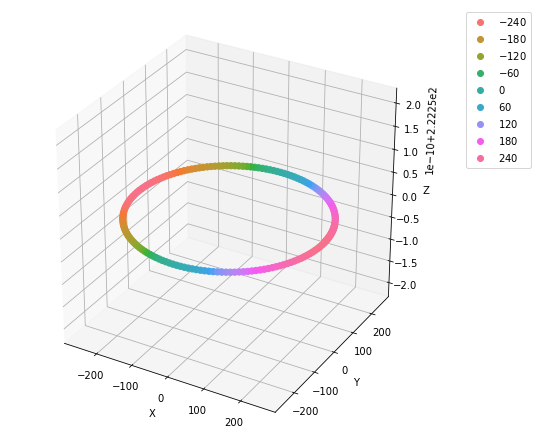

In [30]:
# axes instance
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)

# get colormap from seaborn
cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())

# plot
sc = ax.scatter(xline, yline, zline, s=40, c=xline, marker='o', cmap=cmap, alpha=1)
ax.set_xlabel('X ')
ax.set_ylabel('Y ')
ax.set_zlabel('Z ')

# legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

# save
plt.savefig("scatter_hue", bbox_inches='tight')